In [1]:
import os
import time
import sys
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree, distance_matrix, ConvexHull
from scipy.spatial.distance import pdist, squareform
import umap
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

2025-05-05 17:23:15.030009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 17:23:15.080434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# move to base directory
if os.path.basename(os.getcwd()) == "STmic":
    pass
else:
    os.chdir("../")

print(f"current directory: {os.getcwd()}")

current directory: /gpfs/commons/home/ikothari/STmic


In [3]:
# functions for building/subsetting different geometries from barcode arrays
from scripts.py.utils_geometry import *
# functions for simulating the molecular assay
from scripts.py.utils_simulation import *
# functions for building and assessing reconstructions
from scripts.py.utils_reconstruction import *

In [4]:
centers = np.load("/gpfs/commons/home/ikothari/STmic/notebooks/output/1umcenters.npy", allow_pickle=True)

In [5]:
#convert the center to a dataframe
bc_map = pd.DataFrame(centers, columns=['x', 'y'])
print(bc_map.head())
bc_map['x_y'] = bc_map['x'] * bc_map['y']


            x           y
0  240.314578  249.712723
1  254.535911  134.102051
2   81.976166  138.203032
3  279.261804   37.959083
4  102.010661   55.310494


In [6]:
from scripts.py.utils_geometry import subset_points_within_star, subset_points_within_circle, subset_points_within_regular_polygon

star = subset_points_within_star(bc_map, 75, 150, 5)
star.reset_index(inplace=True)

circle = subset_points_within_circle(bc_map, 150)
circle.reset_index(inplace=True)

square = subset_points_within_regular_polygon(bc_map, 4, 150)
square.reset_index(inplace=True)



In [7]:
params_dict = {}

mers_values = [25]
reaction_time = [1]
num_reads_values = [50]

for i in range(len(mers_values)):
    for j in range(len(num_reads_values)):
        for k in range(len(reaction_time)):
            params_dict[f"{i}_{j}_{k}"] = {
                "mers_per_molc": mers_values[i],
                "num_reads": num_reads_values[j],
                "reaction_time": reaction_time[k],
                "plot": False,
            }

print(f"Testing {len(params_dict)} variations...")
print(num_reads_values)

Testing 1 variations...
[50]


In [8]:
print("Total Reads: ", num_reads_values[0] * len(star))

Total Reads:  106700


In [9]:
dist_matrix = build_distance_matrix(star)
for keys, params in params_dict.items():
        print(params)
        tally_matrix = simulate_concatemerization(
            bc_map=star, dist_matrix=dist_matrix, params=params,verbose=True
        )
        tally_matrix.setdiag(0)
        psuedo_distance_matrix = compute_pseudo_distance(tally_matrix)
        tally_umap = umap_driver(
            psuedo_distance_matrix, n_neighbors=75, min_dist=0.99, metric="euclidean",verbose=True
        )
        star["umap_1"] = pd.DataFrame(tally_umap)[0]
        star["umap_2"] = pd.DataFrame(tally_umap)[1]
        error, error_list = localreconstruction_KNN(star,15)

{'mers_per_molc': 25, 'num_reads': 50, 'reaction_time': 1, 'plot': False}
Compute noise matrix
Add noise to distance matrix
STARTING ACCUMULATION
FINISHED
Max interactions:  65,368.0
Total self-interactions: 662,520.0
Ratio of self-interactions to total interactions: 0.51%


/gpfs/commons/home/ikothari/mambaforge/envs/STmic/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.99, n_epochs=1000, n_jobs=1, n_neighbors=75, random_state=42, verbose=True)
Mon May  5 17:25:46 2025 Construct fuzzy simplicial set
Mon May  5 17:25:56 2025 Finding Nearest Neighbors
Mon May  5 17:25:58 2025 Finished Nearest Neighbor Search
Mon May  5 17:26:00 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Mon May  5 17:26:11 2025 Finished embedding


/scratch/ipykernel_4151052/3760954760.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star["umap_1"] = pd.DataFrame(tally_umap)[0]
/scratch/ipykernel_4151052/3760954760.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star["umap_2"] = pd.DataFrame(tally_umap)[1]


/scratch/ipykernel_4151052/103514463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star['error'] = error_list
/scratch/ipykernel_4151052/103514463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star['umap_1'] = (star['umap_1'] - star['umap_1'].min()) / (star['umap_1'].max() - star['umap_1'].min())
/scratch/ipykernel_4151052/103514463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

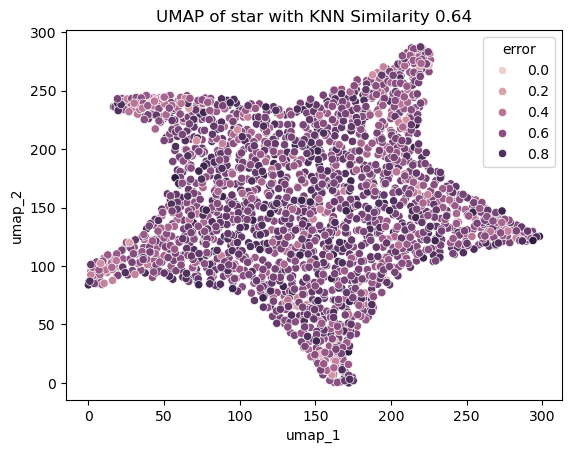

0.6422055607622618


In [10]:
star['error'] = error_list
#normalize and then scale umap to 300 x 300
star['umap_1'] = (star['umap_1'] - star['umap_1'].min()) / (star['umap_1'].max() - star['umap_1'].min())
star['umap_2'] = (star['umap_2'] - star['umap_2'].min()) / (star['umap_2'].max() - star['umap_2'].min())
star['umap_1'] = star['umap_1'] * star['x'].max()
star['umap_2'] = star['umap_2'] * star['y'].max()

sns.scatterplot(x='umap_1', y='umap_2', data=star, hue='error')
plt.title(f"UMAP of star with KNN Similarity {error:.2f}")
plt.show()
print(error)



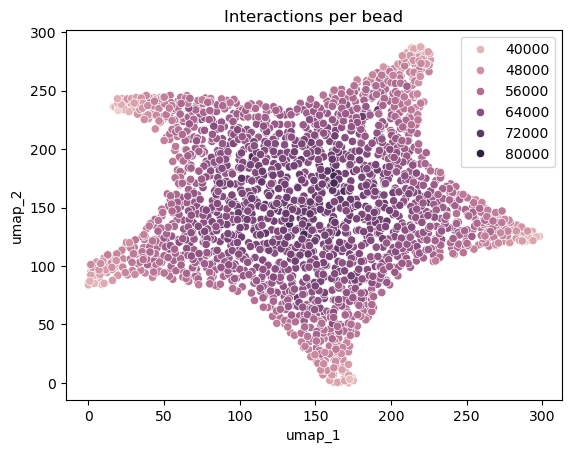

In [11]:
interactions = tally_matrix.sum(axis=0).A1  # Convert sparse matrix to a 1D array
sns.scatterplot(x='umap_1', y='umap_2', data=star, hue=interactions)
plt.title("Interactions per bead")
plt.show()


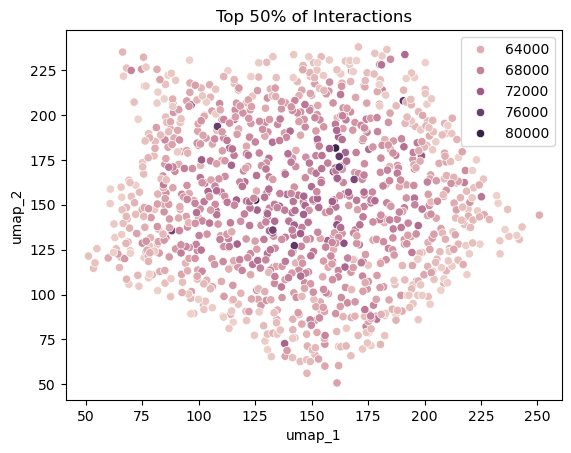

In [12]:
#give me the top 50% of interactions
top_50 = np.percentile(interactions, 50)
top_50_interactions = star[interactions > top_50]
sns.scatterplot(x='umap_1', y='umap_2', data=top_50_interactions, hue=interactions[interactions > top_50])
plt.title("Top 50% of Interactions")
plt.show()

   level_0  index           x           y           x_y      umap_1  \
0        0      1  254.535911  134.102051  34133.787673   65.146736   
1        1      2   81.976166  138.203032  11329.354713  208.625778   
2        2      6  168.728329   55.018792   9283.228885  200.985107   
3        3      8   54.718831   70.416326   3853.099016  282.888458   
4        4     10   94.138243  223.200131  21011.668257  129.851212   

       umap_2     error  
0  245.730789  0.600000  
1  106.108620  0.600000  
2  244.218048  0.600000  
3  134.023834  0.666667  
4   50.503391  0.733333  


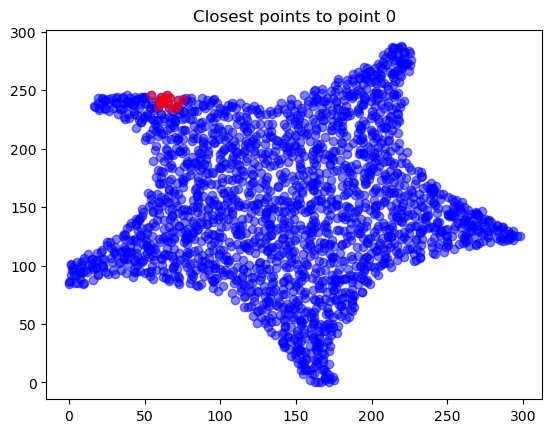

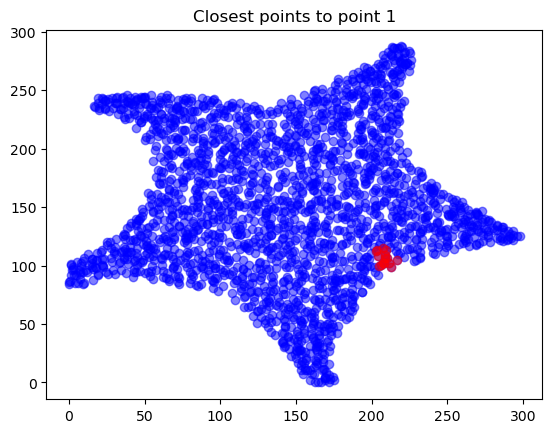

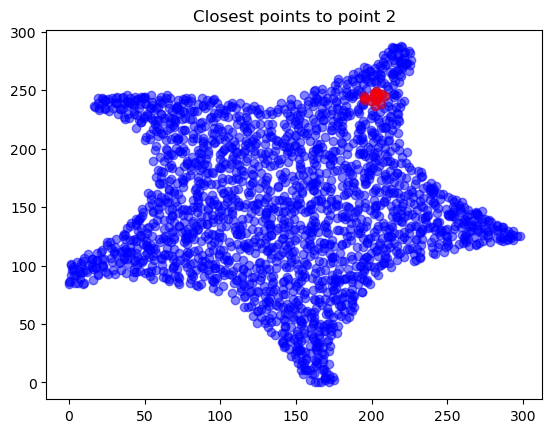

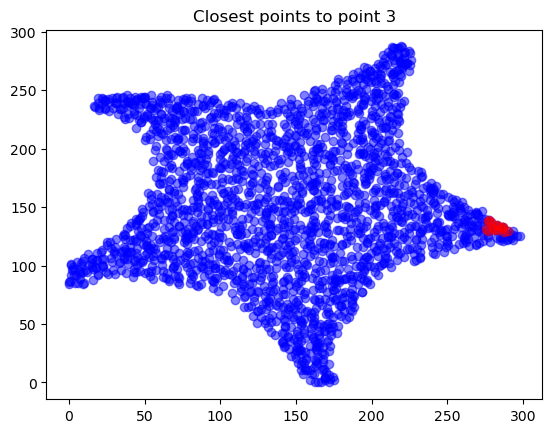

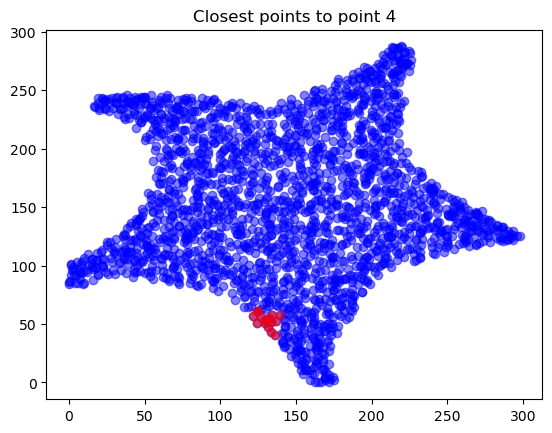

In [13]:
print(star.head())
#find 15 closest points to each point in star
def find_closest_points(star, k=15):
    tree = cKDTree(star[['umap_1', 'umap_2']].values)
    distances, indices = tree.query(star[['umap_1', 'umap_2']].values, k=k)
    return indices
# find the closest points for the first five points and plot
closest_points_indices = find_closest_points(star, k=15)
for i in range(5):
    plt.scatter(star['umap_1'], star['umap_2'], c='blue', alpha=0.5)
    plt.scatter(star['umap_1'][closest_points_indices[i]], star['umap_2'][closest_points_indices[i]], c='red', alpha=0.5)
    plt.title(f"Closest points to point {i}")
    plt.show()

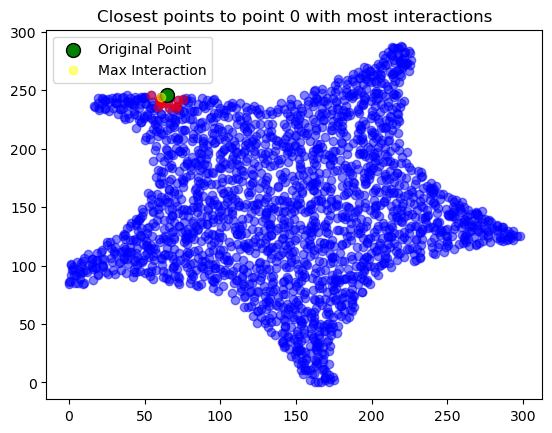

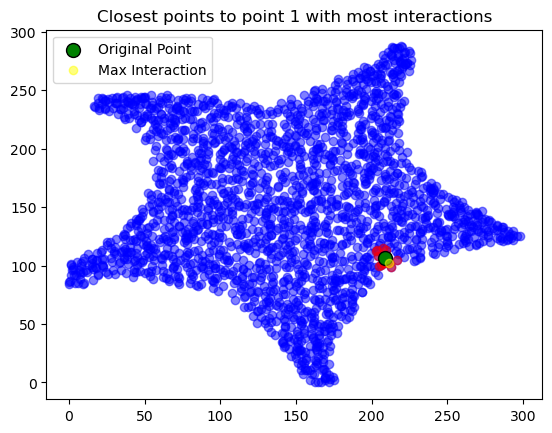

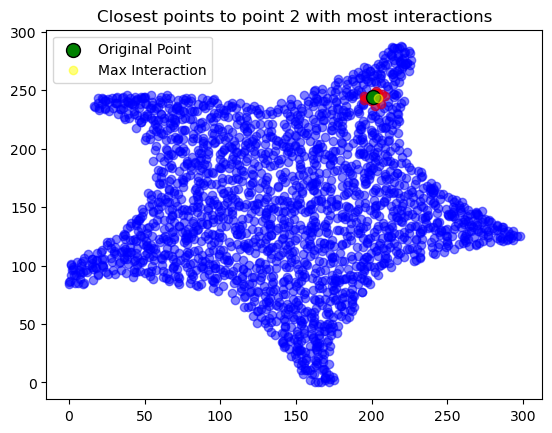

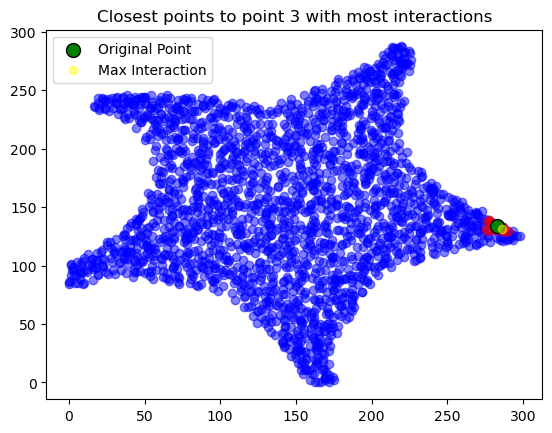

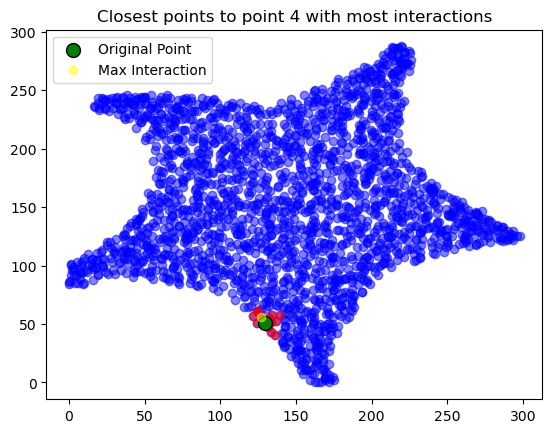

In [14]:
# Calculate closest points indices
closest_points_indices = find_closest_points(star, k=15)

interaction_matrix = tally_matrix.todense()
interaction_matrix = np.array(interaction_matrix)
for i in range(5):
    plt.scatter(star['umap_1'], star['umap_2'], c='blue', alpha=0.5)
    plt.scatter(star['umap_1'][closest_points_indices[i]], star['umap_2'][closest_points_indices[i]], c='red', alpha=0.5)
    # Plot the original point in green
    plt.scatter(star['umap_1'].iloc[i], star['umap_2'].iloc[i], c='green', s=100, edgecolor='black', label='Original Point')
    # Find the index of the point with the most interactions within the closest points
    max_interaction_idx = np.argmax(interaction_matrix[i, closest_points_indices[i]])
    plt.scatter(star['umap_1'][closest_points_indices[i][max_interaction_idx]], star['umap_2'][closest_points_indices[i][max_interaction_idx]], c='yellow', alpha=0.5, label='Max Interaction')
    plt.title(f"Closest points to point {i} with most interactions")
    plt.legend()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Sample 20 random indices from the DataFrame
sample_indices = random.sample(range(len(star)), 20)

# Convert the interaction matrix to a dense NumPy array
interaction_matrix = np.array(tally_matrix.todense())

# Set up the grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

# Loop through each subplot
for plot_idx, i in enumerate(sample_indices):
    ax = axes[plot_idx]
    ax.scatter(star['umap_1'], star['umap_2'], c='blue', alpha=0.3)

    # Get the indices of the top 15 interacting points
    top_interaction_indices = np.argsort(-interaction_matrix[i])[:100]
    
    # Plot top interaction neighbors in red
    ax.scatter(
        star['umap_1'].iloc[top_interaction_indices],
        star['umap_2'].iloc[top_interaction_indices],
        c='red', alpha=0.5, label='Top 15 Interactions'
    )

    # Plot the original point in green
    ax.scatter(
        star['umap_1'].iloc[i], star['umap_2'].iloc[i],
        c='green', s=100, edgecolor='black', label='Original Point'
    )

    # Highlight the strongest interaction in yellow
    max_interaction_idx = top_interaction_indices[0]
    ax.scatter(
        star['umap_1'].iloc[max_interaction_idx],
        star['umap_2'].iloc[max_interaction_idx],
        c='yellow', alpha=0.7, label='Strongest Interaction'
    )

    ax.set_title(f"Top interactions for point {i}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add legend to a separate axis (e.g., top-left plot only)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize='large')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the legend
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Compute local reconstruction error
error, error_list = localreconstruction_KNN(star, 15)
star['error'] = error_list

# Function to find k closest points for all points based on 'x' and 'y' columns
def find_closest_points(star, k=15):
    tree = cKDTree(star[['x', 'y']].values)
    distances, indices = tree.query(star[['x', 'y']].values, k=k)
    return indices

# Compute closest points once
closest_points_indices = find_closest_points(star, k=15)

# Get indices of 20 points with lowest reconstruction error
lowest_error_indices = star.nsmallest(20, 'error').index.tolist()

# Plot in 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for plot_idx, i in enumerate(lowest_error_indices):
    ax = axes[plot_idx]
    ax.scatter(star['umap_1'], star['umap_2'], c='blue', alpha=0.3)

    # Plot 15 closest neighbors in red
    ax.scatter(
        star['umap_1'].iloc[closest_points_indices[i]],
        star['umap_2'].iloc[closest_points_indices[i]],
        c='red', alpha=0.5, label='Closest Neighbors'
    )

    # Plot the original point in green
    ax.scatter(
        star['umap_1'].iloc[i], star['umap_2'].iloc[i],
        c='green', s=100, edgecolor='black', label='Original Point'
    )

    # Add error text near the point
    error_val = star['error'].iloc[i]
    x, y = star['umap_1'].iloc[i], star['umap_2'].iloc[i]
    ax.text(x + 0.1, y, f"Error: {error_val:.3f}", fontsize=10, color='black')

    ax.set_title(f"Highest error point {i}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add legend to the figure (once)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize='large')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # make space for legend
plt.show()


In [ ]:
# Plot in 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for plot_idx, i in enumerate(lowest_error_indices):
    ax = axes[plot_idx]
    ax.scatter(star['umap_1'], star['umap_2'], c='blue', alpha=0.3)

    # Plot 15 closest neighbors in red
    ax.scatter(
        star['umap_1'].iloc[closest_points_indices[i]],
        star['umap_2'].iloc[closest_points_indices[i]],
        c='red', alpha=0.5, label='Closest Neighbors'
    )

    # Plot the original point in green
    ax.scatter(
        star['umap_1'].iloc[i], star['umap_2'].iloc[i],
        c='green', s=100, edgecolor='black', label='Original Point'
    )

    # Highlight the 15 highest interactors in yellow
    top_15_interactors = np.argsort(-interaction_matrix[i, closest_points_indices[i]])[:15]
    ax.scatter(
        star['umap_1'].iloc[closest_points_indices[i][top_15_interactors]],
        star['umap_2'].iloc[closest_points_indices[i][top_15_interactors]],
        c='yellow', s=100, label='Top 15 Interactors', alpha=0.1
    )

    # Add error text near the point
    error_val = star['error'].iloc[i]
    x, y = star['umap_1'].iloc[i], star['umap_2'].iloc[i]
    ax.text(x + 0.1, y, f"Error: {error_val:.3f}", fontsize=10, color='black')

    ax.set_title(f"Highest error point {i}")
    ax.set_xticks([])
    ax.set_yticks([])

# Add legend to the figure (once)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize='large')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # make space for legend
plt.show()


In [ ]:
error, error_list = localreconstruction_KNN(star,15)
sns.scatterplot(x='umap_1', y='umap_2', data=star, hue=error_list)
plt.title(f"UMAP of star with KNN Similarity {error:.2f}")
plt.show()


In [ ]:
#plot interactions as a histrogram
plt.hist(interactions, bins=50)

## Testing Matching to Mask Using OT

In [ ]:
import matplotlib.pyplot as plt
mask_centers = generate_array(0.76,300,300,2.7)


In [ ]:
bc_map_mask = pd.DataFrame(mask_centers, columns=['x', 'y'])
star_mask = subset_points_within_star(bc_map_mask, 75, 150, 5)
star_mask.reset_index(inplace=True)
print(star_mask.head())

In [ ]:
target = star_mask[['x', 'y']].values
target = np.array(target)
source = star[['umap_1', 'umap_2']].values
source = np.array(source)





In [ ]:
import ot
from scipy.spatial.distance import cdist

# Compute the cost matrix
C = cdist(source, target, 'sqeuclidean')

# Normalize the distributions to ensure they have the same sum
source_weights = np.ones(source.shape[0]) / source.shape[0]
target_weights = np.ones(target.shape[0]) / target.shape[0]

# Compute the transport plan
transport_plan = ot.emd(source_weights, target_weights, C, numItermax=1000000)

# Map each source point to the target point with the highest transport weight
mapped_indices = np.argmax(transport_plan, axis=1)
mapped_points = target[mapped_indices]

# Add the mapped points to the source dataframe for visualization
star['mapped_x'] = mapped_points[:, 0]
star['mapped_y'] = mapped_points[:, 1]

# Visualize the mapping
plt.figure(figsize=(10, 6))
plt.scatter(star['umap_1'], star['umap_2'], label='Source Points', alpha=0.6)
plt.scatter(target[:, 0], target[:, 1], label='Target Points', alpha=0.6)
for i in range(len(star)):
    plt.plot([star['umap_1'].iloc[i], star['mapped_x'].iloc[i]],
             [star['umap_2'].iloc[i], star['mapped_y'].iloc[i]], 'r-', alpha=0.3)
plt.legend()
plt.title("Mapping Source Points to Target Points")
plt.show()

In [ ]:
star_eval = star.copy()
star_eval['umap_1'] = star['mapped_x']
star_eval['umap_2'] = star['mapped_y']
error, error_list = localreconstruction_KNN(star_eval, 15)
star_eval['error'] = error_list
print(error)

In [ ]:
sns.scatterplot(x='umap_1', y='umap_2', data=star_eval, hue='error')
plt.title(f"UMAP of star following OT embedding with KNN Similarity {error:.2f}")


## Test Local OT 

In [ ]:
import numpy as np
import ot
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Parameters
k_neighbors = 2  # How many neighbors to consider for each source point

# Normalize weights
source_weights = np.ones(source.shape[0]) / source.shape[0]
target_weights = np.ones(target.shape[0]) / target.shape[0]

# Find local neighborhoods
nn = NearestNeighbors(n_neighbors=k_neighbors)
nn.fit(target)
distances, indices = nn.kneighbors(source)

# Prepare to store the mapped points
mapped_points = np.zeros_like(source)

# For each source point, solve a *local* OT problem
for i in range(source.shape[0]):
    source_point = source[i].reshape(1, -1)
    target_neighbors = target[indices[i]]  # k nearest neighbors

    # Local cost matrix (only between the single source point and its neighbors)
    C_local = cdist(source_point, target_neighbors, 'sqeuclidean')

    # Local weights
    source_weight_local = np.array([1.0])  # Only 1 point
    target_weights_local = np.ones(k_neighbors) / k_neighbors  # Uniform over neighbors

    # Solve local OT
    transport_plan_local = ot.emd(source_weight_local, target_weights_local, C_local)

    # Find the neighbor with the highest transport weight
    mapped_idx = np.argmax(transport_plan_local[0])  # Only one source, so row 0
    mapped_points[i] = target_neighbors[mapped_idx]

# Add the mapped points to the source dataframe
star['mapped_x'] = mapped_points[:, 0]
star['mapped_y'] = mapped_points[:, 1]

# Visualize the mapping
plt.figure(figsize=(10, 6))
plt.scatter(star['umap_1'], star['umap_2'], label='Source Points', alpha=0.6)
plt.scatter(target[:, 0], target[:, 1], label='Target Points', alpha=0.6)
for i in range(len(star)):
    plt.plot([star['umap_1'].iloc[i], star['mapped_x'].iloc[i]],
             [star['umap_2'].iloc[i], star['mapped_y'].iloc[i]], 'r-', alpha=0.3)
plt.legend()
plt.title(f"Local OT Mapping (k={k_neighbors})")
plt.show()


In [ ]:
sns.scatterplot(x='mapped_x', y='mapped_y', data=star, hue='x_y')
star_eval_2 = star.copy()
star_eval_2['umap_1'] = star['mapped_x']
star_eval_2['umap_2'] = star['mapped_y']
error, error_list = localreconstruction_KNN(star_eval_2, 15)
print(error)

In [ ]:
import numpy as np
import ot
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg

# Parameters
k_neighbors = 10         # local neighborhood size
sinkhorn_reg = 0.01      # epsilon for Sinkhorn regularization
laplacian_smoothing = 0.1  # amount of Laplacian smoothing

# Normalize distributions
source_weights = np.ones(source.shape[0]) / source.shape[0]
target_weights = np.ones(target.shape[0]) / target.shape[0]

# Find local neighborhoods
nn = NearestNeighbors(n_neighbors=k_neighbors)
nn.fit(target)
distances, indices = nn.kneighbors(source)

# Store the transport plans locally
local_transport_plans = np.zeros((source.shape[0], k_neighbors))

# Solve Local Sinkhorn OT for each point
for i in range(source.shape[0]):
    source_point = source[i].reshape(1, -1)
    target_neighbors = target[indices[i]]

    C_local = cdist(source_point, target_neighbors, 'sqeuclidean')

    a = np.array([1.0])  # source distribution (only one point)
    b = np.ones(k_neighbors) / k_neighbors  # target distribution over k neighbors

    # Solve Sinkhorn
    transport_plan_local = ot.sinkhorn(a, b, C_local, sinkhorn_reg)
    
    local_transport_plans[i] = transport_plan_local[0]  # shape (k_neighbors,)

# --- Laplacian Smoothing ---

# Build a kNN graph over the source points
source_nn = NearestNeighbors(n_neighbors=5)
source_nn.fit(source)
src_distances, src_indices = source_nn.kneighbors(source)

# Build sparse adjacency matrix
n_source = source.shape[0]
row_idx = np.repeat(np.arange(n_source), src_indices.shape[1])
col_idx = src_indices.flatten()
data = np.ones_like(row_idx)
W = scipy.sparse.coo_matrix((data, (row_idx, col_idx)), shape=(n_source, n_source))

# Degree matrix
D = scipy.sparse.diags(W.sum(axis=1).A1)

# Graph Laplacian
L = D - W

# Solve smoothed transport plans
# (I + alpha * L) * smoothed = original
I = scipy.sparse.eye(n_source)
smooth_operator = I + laplacian_smoothing * L
smoothed_transport_plans = scipy.sparse.linalg.spsolve(smooth_operator, local_transport_plans)

# Map each source to the weighted average of its neighbors
mapped_points = np.zeros((source.shape[0], source.shape[1]))
for i in range(source.shape[0]):
    neighbor_targets = target[indices[i]]  # (k_neighbors, d)
    weights = smoothed_transport_plans[i]  # (k_neighbors,)
    weights /= weights.sum()  # re-normalize after smoothing (important)
    mapped_points[i] = np.sum(neighbor_targets * weights[:, np.newaxis], axis=0)

# --- Visualization ---

# Add the mapped points to the dataframe
star['mapped_x'] = mapped_points[:, 0]
star['mapped_y'] = mapped_points[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(star['umap_1'], star['umap_2'], label='Source Points', alpha=0.6)
plt.scatter(target[:, 0], target[:, 1], label='Target Points', alpha=0.6)
for i in range(len(star)):
    plt.plot([star['umap_1'].iloc[i], star['mapped_x'].iloc[i]],
             [star['umap_2'].iloc[i], star['mapped_y'].iloc[i]], 'r-', alpha=0.3)
plt.legend()
plt.title(f"Local OT + Sinkhorn + Laplacian Smoothing (k={k_neighbors})")
plt.show()


In [ ]:
sns.scatterplot(x='mapped_x', y='mapped_y', data=star, hue='x_y')


## Testing Dimension Reduction Methods which emphasize local reconstruction

0.5508591065292097


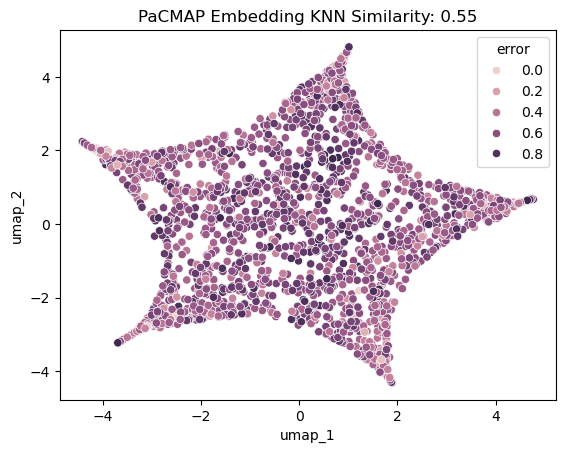

In [16]:
import pacmap

X = psuedo_distance_matrix.todense()
X = np.array(X)
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10,MN_ratio= 0.1, FP_ratio =0.1)
X_transformed = embedding.fit_transform(X)

star_eval = star.copy()
star_eval['umap_1'] = X_transformed[:, 0]
star_eval['umap_2'] = X_transformed[:, 1]
star_eval['error'] = error_list 
error, error_list = localreconstruction_KNN(star_eval, 15)
sns.scatterplot(x='umap_1', y='umap_2', data=star_eval, hue='error')
plt.title("PaCMAP Embedding KNN Similarity: {:.2f}".format(error))
print(error)

# Testing Diffusion Maps

In [ ]:
import numpy as np
from scipy.sparse import csgraph
from sklearn.manifold import SpectralEmbedding

X = np.asarray(psuedo_distance_matrix.todense())
W = ( X + X.T) / 2

embedding = SpectralEmbedding(
    n_components=2,
    affinity='precomputed',
).fit_transform(W)

plt.title("Spectral Embedding")
star_eval = star.copy()
star_eval['umap_1'] = embedding[:, 0]
star_eval['umap_2'] = embedding[:, 1]
star_eval['error'] = error_list
sns.scatterplot(x='umap_1', y='umap_2', data=star_eval, hue='error')
plt.title("Spectral Embedding KNN Similarity: {:.2f}".format(error))
error, error_list = localreconstruction_KNN(star_eval, 15)
print(error)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_array(W)
pos = nx.spring_layout(G)  # or try forceatlas2 via fa2 package
nx.draw(G, pos, node_size=50, with_labels=False)


# Wasserstein with Mahalanobis Distance

In [ ]:
import numpy as np
import ot
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Assume source and target are (n, d) and (m, d) numpy arrays
# Step 1: Compute covariance matrix from concatenated data or just source
star_eval = star.copy()
cov = np.cov(np.vstack([source, target]).T)
VI = np.linalg.inv(cov)  # Inverse covariance matrix

# Step 2: Compute cost matrix using Mahalanobis distance
C = cdist(source, target, metric='mahalanobis', VI=VI)

# Step 3: Normalize distributions
source_weights = np.ones(source.shape[0]) / source.shape[0]
target_weights = np.ones(target.shape[0]) / target.shape[0]

# Step 4: Compute transport plan
transport_plan = ot.emd(source_weights, target_weights, C, numItermax=1000000)

# Step 5: Map each source point to the target point with the highest transport weight
mapped_indices = np.argmax(transport_plan, axis=1)
mapped_points = target[mapped_indices]

# Step 6: Visualize
star_eval['mapped_x'] = mapped_points[:, 0]
star_eval['mapped_y'] = mapped_points[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(star_eval['umap_1'], star_eval['umap_2'], label='Source Points', alpha=0.6)
plt.scatter(target[:, 0], target[:, 1], label='Target Points', alpha=0.6)
for i in range(len(star)):
    plt.plot([star_eval['umap_1'].iloc[i], star_eval['mapped_x'].iloc[i]],
             [star_eval['umap_2'].iloc[i], star_eval['mapped_y'].iloc[i]], 'r-', alpha=0.3)
plt.legend()
plt.title("Mapping Source Points to Target Points (Mahalanobis Distance)")
plt.show()


In [ ]:
sns.scatterplot(x='mapped_x', y='mapped_y', data=star_eval, hue='x_y')
star_eval['umap_1'] = star_eval['mapped_x']
star_eval['umap_2'] = star_eval['mapped_y']
plt.title(f"UMAP of star following OT embedding using Mahalnobis with KNN Similarity {error:.2f}")
error, error_list = localreconstruction_KNN(star_eval, 15)
print(error)

In [ ]:
interactions = tally_matrix.sum(axis=0).A1  # Convert sparse matrix to a 1D array
star['interactions'] = interactions
sns.scatterplot(x='x', y='y', data=star, hue='interactions')

## Graph Based Matching for OT

In [ ]:
%pip install networkx

In [ ]:
for i in range(len(source_points)):
    G.nodes[i]['feat'] = source_points[i]  # Use UMAP coordinates as features


In [ ]:
Gq = nx.Graph()
for i in range(len(target_points)):
    Gq.add_node(i, pos=(target_points[i][0], target_points[i][1]), feat=target_points[i])

# k-NN connections
nbrs_q = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(target_points)
distances_q, indices_q = nbrs_q.kneighbors(target_points)

for i in range(len(target_points)):
    for j in range(1, 16):
        neighbor_idx = indices_q[i][j]
        dist = distances_q[i][j]
        Gq.add_edge(i, neighbor_idx, weight=dist)


In [ ]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

# Assume source_points and target_points are already defined
source_points = star[['umap_1', 'umap_2']].values
target_points = star_mask[['x', 'y']].values

# Create a graph from the source points
G = nx.Graph()

# Add nodes with positions
for i in range(len(source_points)):
    G.add_node(i, pos=(source_points[i][0], source_points[i][1]))

# Find 15 nearest neighbors for each point
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(source_points)  # 16 because it includes itself
distances, indices = nbrs.kneighbors(source_points)

# Add edges to the graph based on 15 nearest neighbors
for i in range(len(source_points)):
    for j in range(1, 16):  # start from 1 to skip self (distance=0 to itself)
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G.add_edge(i, neighbor_idx, weight=dist)


In [ ]:
#visualize my graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=50, with_labels=False)
plt.title("Graph of Source Points")
plt.show()

In [ ]:
import networkx as nx
import numpy as np
import ot

def extract_khop_subgraph(G, node, k):
    return nx.ego_graph(G, node, radius=k)

def compute_fgw_distance(C1, C2, p, q, M, alpha=0.5):
    # C1, C2: intra-graph distance matrices
    # p, q: node distributions
    # M: cost matrix between features
    return ot.gromov.fused_gromov_wasserstein(M, C1, C2, p, q, 'square_loss', alpha=alpha)

def SSOT(Gs, Gq, k=2, alpha=0.5):
    best_score = float('inf')
    best_subgraph = None
    Cq = nx.floyd_warshall_numpy(Gq).astype(float)  # distance matrix of Gq
    fq = np.array([Gq.nodes[n]['feat'] for n in Gq.nodes])
    q = np.ones(len(Gq)) / len(Gq)

    for v in Gs.nodes:
        Gv = extract_khop_subgraph(Gs, v, k)
        if len(Gv) < len(Gq):
            continue
        Cv = nx.floyd_warshall_numpy(Gv).astype(float)
        fv = np.array([Gv.nodes[n]['feat'] for n in Gv.nodes])
        p = np.ones(len(Gv)) / len(Gv)

        M = ot.dist(fv, fq, metric='euclidean')
        fgw_dist = compute_fgw_distance(Cv, Cq, p, q, M, alpha)

        if fgw_dist < best_score:
            best_score = fgw_dist
            best_subgraph = Gv

    return best_subgraph


# Testing Gromov Wasserstein Dimensionality Reduction

In [ ]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

interaction_matrix = tally_matrix.todense()
interaction_matrix = np.array(interaction_matrix)
#for each column in interaction matrix contrust a knn graph
G = nx.Graph()
for i in range(interaction_matrix.shape[1]):
    G.add_node(i, pos=(star['umap_1'].iloc[i], star['umap_2'].iloc[i]), feat=interaction_matrix[:, i])
    # Add edges based on k-NN
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(interaction_matrix[:, i].reshape(-1, 1))
    distances, indices = nbrs.kneighbors(interaction_matrix[:, i].reshape(-1, 1))
    for j in range(1, 15):  # start from 1 to skip self (distance=0 to itself)
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G.add_edge(i, neighbor_idx, weight=dist)
#visualize my graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=50, with_labels=False)
plt.title("Graph of Source Points")
plt.show()



In [ ]:
#contrust a knn graph for the UMAP points
G = nx.Graph()
for i in range(interaction_matrix.shape[1]):
    G.add_node(i, pos=(star['umap_1'].iloc[i], star['umap_2'].iloc[i]), feat=interaction_matrix[:, i])
    # Add edges based on k-NN
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(star[['umap_1', 'umap_2']].values)
    distances, indices = nbrs.kneighbors(star[['umap_1', 'umap_2']].values)
    for j in range(1, 15):  # start from 1 to skip self (distance=0 to itself)
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G.add_edge(i, neighbor_idx, weight=dist)
#visualize my graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=50, with_labels=False)
plt.title("Graph of Source Points")
plt.show()

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import ot  # POT library

# Build first graph based on interaction matrix
n = interaction_matrix.shape[1]
G1 = nx.Graph()
for i in range(n):
    G1.add_node(i, feat=interaction_matrix[:, i])
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(interaction_matrix[:, i].reshape(-1, 1))
    distances, indices = nbrs.kneighbors(interaction_matrix[:, i].reshape(-1, 1))
    for j in range(1, 15):
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G1.add_edge(i, neighbor_idx, weight=dist)

# Build second graph based on UMAP embedding
positions = star[['umap_1', 'umap_2']].values
G2 = nx.Graph()
for i in range(n):
    G2.add_node(i, pos=tuple(positions[i]), feat=positions[i])
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(positions)
    distances, indices = nbrs.kneighbors(positions)
    for j in range(1, 15):
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G2.add_edge(i, neighbor_idx, weight=dist)

# Get distance matrices (shortest path based)
D1 = nx.floyd_warshall_numpy(G1).astype(np.float64)
D2 = nx.floyd_warshall_numpy(G2).astype(np.float64)

# Uniform weights over nodes
p = ot.unif(n)
q = ot.unif(n)

# Compute Gromov-Wasserstein transport plan
gw_loss, T, _ = ot.gromov.gromov_wasserstein2(D1, D2, p, q, 'square_loss', verbose=True, log=False)

print("Gromov-Wasserstein Loss:", gw_loss)

# Optionally: visualize the transport plan as a heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(T, cmap="viridis")
plt.title("Gromov-Wasserstein Transport Plan")
plt.xlabel("UMAP space")
plt.ylabel("Interaction space")
plt.show()


Transport plan idea: Filter out points between UMAP and interaction matrix nearest neighbours - UMAP pruning and form optimal transport between 2d nearest neighbours space and NxN interaction space, removing weak/irrelevant connections so that GW focuses on meaniful graph structure, frm there if we have high KNN accuracy we can easily fit to the shape of the geometry via OT 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Step 1: Extract UMAP coordinates
umap_coords = star[['umap_1', 'umap_2']].values
n_points = umap_coords.shape[0]

# Step 2: Get UMAP-based nearest neighbors
umap_nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(umap_coords)
_, umap_indices = umap_nbrs.kneighbors(umap_coords)  # shape: (n_points, 50)

# Step 3: Convert sparse interaction matrix to dense
interaction_matrix = np.asarray(tally_matrix.todense())  # shape: (n_points, n_points)

# Step 4: For each column (i.e. source point), get top 50 interactors
topk_interactors = np.argsort(-interaction_matrix, axis=0)[:50, :]  # shape: (50, n_points)

# Step 5: Compare overlap between UMAP neighbors and interaction-based top neighbors
overlap_ratios = []

for i in range(n_points):
    umap_set = set(umap_indices[i])
    interact_set = set(topk_interactors[:, i])
    overlap = len(umap_set.intersection(interact_set))
    overlap_ratios.append(overlap / 50)

# Step 6: Print summary and plot
print(f"Average overlap: {np.mean(overlap_ratios):.3f}")
print(f"Median overlap: {np.median(overlap_ratios):.3f}")

plt.hist(overlap_ratios, bins=20, alpha=0.7)
plt.xlabel("Overlap ratio (UMAP vs Interaction Matrix)")
plt.ylabel("Number of points")
plt.title("Distribution of Neighbor Overlap Ratios")
plt.grid(True)
plt.tight_layout()
plt.show()

#remove all non overlapping points from the interaction matrix
overlap_ratios = np.array(overlap_ratios)
overlap_mask = overlap_ratios > 0
interaction_matrix_filtered = interaction_matrix[overlap_mask][:, overlap_mask]
# Create a new graph based on the filtered interaction matrix
G_filtered = nx.Graph()
for i in range(interaction_matrix_filtered.shape[0]):
    G_filtered.add_node(i, feat=interaction_matrix_filtered[:, i])
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(interaction_matrix_filtered[:, i].reshape(-1, 1))
    distances, indices = nbrs.kneighbors(interaction_matrix_filtered[:, i].reshape(-1, 1))
    for j in range(1, 15):
        neighbor_idx = indices[i][j]
        dist = distances[i][j]
        G_filtered.add_edge(i, neighbor_idx, weight=dist)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import ot

# Parameters
k = 30
subset_size = 300

# Get UMAP coordinates
umap_coords = star[['umap_1', 'umap_2']].values
n_points = umap_coords.shape[0]

# --- Graph 1: UMAP-based kNN graph ---
umap_knn = NearestNeighbors(n_neighbors=k).fit(umap_coords)
_, umap_indices = umap_knn.kneighbors(umap_coords)

C_umap = np.full((n_points, n_points), np.inf)
for i in range(n_points):
    for j in umap_indices[i]:
        dist = np.sum((umap_coords[i] - umap_coords[j])**2)
        C_umap[i, j] = dist
        C_umap[j, i] = dist

# --- Graph 2: Interaction-based top-k graph ---
interaction_matrix = np.asarray(tally_matrix.todense())
topk_interactors = np.argsort(-interaction_matrix, axis=0)[1:k+1, :]  # skip self

C_interact = np.full((n_points, n_points), np.inf)
for i in range(n_points):
    for j in topk_interactors[:, i]:
        C_interact[i, j] = 1.0 / (interaction_matrix[j, i] + 1e-9)
        C_interact[j, i] = C_interact[i, j]

# --- Subsample ---
subset_idx = np.random.choice(n_points, size=subset_size, replace=False)
C1 = C_interact[subset_idx][:, subset_idx]
C2 = C_umap[subset_idx][:, subset_idx]
C1[C1 == np.inf] = 1e6
C2[C2 == np.inf] = 1e6
C1 = np.nan_to_num(C1, nan=1e6)
C2 = np.nan_to_num(C2, nan=1e6)
X2 = umap_coords[subset_idx]

# --- Gromov-Wasserstein transport ---
n = C1.shape[0]
p = np.ones(n) / n
q = np.ones(n) / n
T = ot.gromov.gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', verbose=True)

# --- Project interaction points into UMAP space ---
projected_points = T @ X2  # shape: (n, 2)

# --- Override the original UMAP coordinates in star ---
star.loc[subset_idx, 'umap_1'] = projected_points[:, 0]
star.loc[subset_idx, 'umap_2'] = projected_points[:, 1]

# --- Visualize the mapping ---
plt.figure(figsize=(10, 6))
plt.scatter(X2[:, 0], X2[:, 1], label='Original UMAP Subset', alpha=0.6)
plt.scatter(projected_points[:, 0], projected_points[:, 1], label='Projected Interaction Points', alpha=0.6)
for i in range(n):
    plt.plot([X2[i, 0], projected_points[i, 0]], [X2[i, 1], projected_points[i, 1]], 'r-', alpha=0.2)
plt.legend()
plt.title("Gromov-Wasserstein: Interaction Graph → UMAP Space")
plt.axis('equal')
plt.grid(True)
plt.show()


In [ ]:
sns.scatterplot(x='umap_1', y='umap_2', data=star, hue='x_y')
error, error_list = localreconstruction_KNN(star, 15)
print(error)

In [ ]:
%pip install torch

In [ ]:
import torch
import numpy as np
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import ot  # POT
from scipy.stats import gaussian_kde

# === INPUTS ===

interaction_matrix = psuedo_distance_matrix.todense()
interaction_matrix = np.array(interaction_matrix)
n = interaction_matrix.shape[0]

# Optional: mask as a 2D density image or sampled points (n_points, 2)
density_mask_samples =  star_mask[['x', 'y']].values

# === INITIAL EMBEDDING ===
import umap
embedding = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="precomputed").fit_transform(1 - interaction_matrix)

# Convert to torch
X = torch.tensor(embedding, dtype=torch.float32, requires_grad=True)

optimizer = torch.optim.Adam([X], lr=1e-2)
epochs = 500

# === LOCAL NEIGHBORHOOD LOSS ===
def local_loss(X, I, k=10):
    with torch.no_grad():
        nbrs = NearestNeighbors(n_neighbors=k, metric="precomputed").fit(1 - I)
        neighbors = nbrs.kneighbors(return_distance=False)
    loss = 0.
    for i in range(X.shape[0]):
        xi = X[i]
        for j in neighbors[i]:
            if i != j:
                xj = X[j]
                target_dist = 1.0 / (I[i, j] + 1e-3)
                pred_dist = torch.norm(xi - xj)
                loss += (pred_dist - target_dist)**2
    return loss / X.shape[0]

# === GLOBAL OT LOSS ===
def global_ot_loss(X, samples_mask, eps=0.3):
    n = X.shape[0]
    x_embed = X.detach().cpu().numpy()
    y_target = samples_mask

    # Compute uniform histograms
    a = np.ones((n,)) / n
    b = np.ones((y_target.shape[0],)) / y_target.shape[0]

    # Cost matrix (squared Euclidean), add small epsilon
    M = ot.dist(x_embed, y_target, metric='euclidean') ** 2
    M += 1e-9  # small epsilon for numerical stability

    # Sinkhorn divergence
    G = ot.sinkhorn(a, b, M, reg=eps)
    return torch.tensor(np.sum(G), dtype=torch.float32)


# === OPTIMIZATION LOOP ===
for epoch in range(epochs):
    optimizer.zero_grad()

    l_local = local_loss(X, interaction_matrix, k=10)
    l_global = global_ot_loss(X, density_mask_samples)

    loss = 5.0 * l_local + 1.0 * l_global
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Local={l_local.item():.4f}, Global={l_global.item():.4f}")

# === VISUALIZATION ===
X_final = X.detach().cpu().numpy()
plt.scatter(*X_final.T, s=5, alpha=0.6, label="Embedding")
plt.scatter(*density_mask_samples.T, s=2, alpha=0.2, label="Mask")
plt.legend()
plt.title("Final Refined Embedding vs Mask Samples")
plt.axis("equal")
plt.show()


In [ ]:
#visualize only the embedding
plt.scatter(*X_final.T, c=star['x_y'], s=5, alpha=0.6, cmap='viridis', label="Embedding")
plt.colorbar(label='x_y')
plt.title("Final Refined Embedding Colored by x_y")



## Testing Graph Pruning Strategies

In [ ]:
A = tally_matrix.todense()
A2 = A @ A
n = A.shape[0]

Ai3 = np.zeros((n, n))
for a in range(n):
    bs = np.where(A[:, a] > 0)[0]
    for b in bs:
        c1 = set(np.where(A2[b, :] > 0)[0])
        c2 = set(np.where(A2[a, :] > 0)[0])
        common_nodes = c1.union(c2)

        for c in common_nodes:
            update_val = (A2[b, c] - A[b, a] * A[c, a]) * A[b, a]
            Ai3[c, a] += update_val





In [ ]:
import numpy as np

def calc_indirect_paths_connected_single_input(indptr, indices, data):
    n = len(indptr) - 1
    squared_data = []
    squared_indices = []
    squared_indptr = [0]

    for i in range(n):  # rows
        row_start = indptr[i]
        row_end = indptr[i + 1]
        row_indices = indices[row_start:row_end]
        row_data = data[row_start:row_end]

        sq_row = {}
        for j in range(len(row_indices)):
            inner_idx = row_indices[j]
            inner_val = row_data[j]
            inner_start = indptr[inner_idx]
            inner_end = indptr[inner_idx + 1]
            inner_indices = indices[inner_start:inner_end]
            inner_data = data[inner_start:inner_end]
            for k in range(len(inner_indices)):
                idx_k = inner_indices[k]
                val_k = inner_data[k]
                if idx_k != i:  # remove diagonal
                    if idx_k in sq_row:
                        sq_row[idx_k] += inner_val * val_k
                    else:
                        sq_row[idx_k] = inner_val * val_k

        squared_indices.extend(sq_row.keys())
        squared_data.extend(sq_row.values())
        squared_indptr.append(len(squared_indices))

    squared_data = np.array(squared_data, dtype=data.dtype)
    squared_indices = np.array(squared_indices, dtype=np.int32)
    squared_indptr = np.array(squared_indptr, dtype=np.int32)

    new_data = np.empty_like(data, dtype=data.dtype)

    for column_id in range(len(indptr) - 1):  # node 1
        slice_spairs = slice(indptr[column_id], indptr[column_id + 1])
        indices_spairs = indices[slice_spairs]
        edge_weights_spairs = data[slice_spairs]
        length_column = len(indices_spairs)

        for j in range(length_column):  # node 2
            row_id = indices_spairs[j]
            connection_n1_n2 = edge_weights_spairs[j]

            slice_spairssq = slice(squared_indptr[row_id], squared_indptr[row_id + 1])
            indices_spairssq = squared_indices[slice_spairssq]
            edge_weights_spairssq = squared_data[slice_spairssq]

            aux = np.concatenate((indices_spairs, indices_spairssq))
            aux_sort_indices = np.argsort(aux, kind='mergesort')

            new_weight = 0
            for k in range(len(aux_sort_indices) - 1):  # node 3
                i1 = aux_sort_indices[k]
                i2 = aux_sort_indices[k + 1]
                if aux[i1] == aux[i2]:
                    idx = aux[i1]
                    if i1 < length_column:
                        connection_n1_n3 = edge_weights_spairs[i1]
                        connection_n2_n3 = edge_weights_spairssq[i2 - length_column] - (connection_n1_n2 * connection_n1_n3)
                        new_weight += connection_n1_n3 * connection_n2_n3

            new_data[indptr[column_id] + j] = new_weight

    return new_data


In [ ]:
def minpath_dense(np_pairs):
    # For asymmetric adjacency matrices of bipartite graphs
    pairs_cubed = np_pairs @ np_pairs.T @ np_pairs
    # The number of edges squared represents, for each node, the sum of all its edges squared
    edges_sq = np_pairs**2
    nedges_sq_axis0 = np.asarray(edges_sq.sum(axis=0))
    nedges_sq_axis1 = np.asarray(edges_sq.sum(axis=1))
    # Expected values for direct links between two nodes after taking three steps
    # are then found by adding these together for two connected nodes,
    # subtracting the edge squared itself (otherwise it would be counted double)
    # and multiplying by their respective edge
    direct_links = (nedges_sq_axis0[None, :] + nedges_sq_axis1[:, None] - edges_sq) * np_pairs
    indirect_paths = pairs_cubed - direct_links
    ip = np.where(np_pairs, indirect_paths, 0)
    return ip

Take the minipath output and dimensionally reduce, increase the pruning threshold afterwards to see if we can isolate neighbourhoods as desired

In [ ]:
import numpy as np

indirect_data = calc_indirect_paths_connected_single_input(
    np.array(spairs.indptr, dtype=np.int32),
    np.array(spairs.indices, dtype=np.int32),
    np.array(spairs.data, dtype=np.float32),
)


In [10]:
A = csr_matrix(tally_matrix.todense())
A2 = A @ A

In [20]:
psuedo_distance_matrix = compute_pseudo_distance(A2)
psuedo_distance_matrix = np.asarray(psuedo_distance_matrix)
embedding = umap_driver(psuedo_distance_matrix)

/gpfs/commons/home/ikothari/mambaforge/envs/STmic/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.18322399250234303


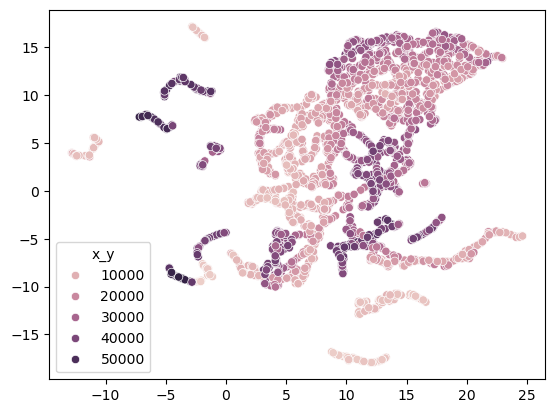

In [22]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], data=star, hue='x_y')
star_eval = star.copy()
star_eval['umap_1'] = embedding[:, 0]
star_eval['umap_2'] = embedding[:, 1]
error, error_list = localreconstruction_KNN(star_eval, 15)
print(error)

In [12]:
#normalize A2
A2 = A2 / np.max(A2)
A2 = A2.todense()
A2 = np.array(A2)



In [13]:
embedding = umap_driver(A2)

/gpfs/commons/home/ikothari/mambaforge/envs/STmic/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

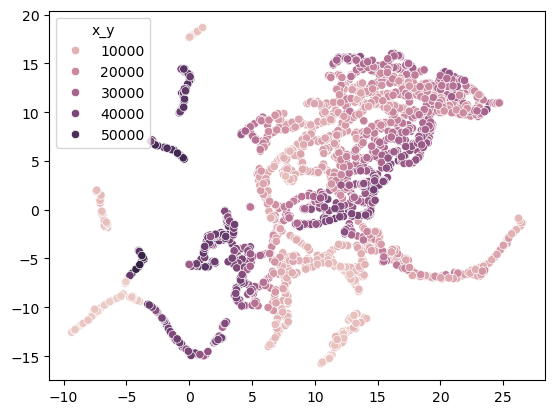

In [14]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], data=star, hue='x_y')

In [ ]:
psuedo_distance_matrix = compute_pseudo_distance(Ai3)
psuedo_distance_matrix = np.array(psuedo_distance_matrix)

In [ ]:
embedding = umap_driver(psuedo_distance_matrix)

In [ ]:
from sklearn.manifold import MDS
Ai3 = Ai3 * Ai3.T
embedding = MDS(n_components=2, dissimilarity='precomputed')
coords = embedding.fit_transform(1 - Ai3)
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], data=star, hue='x_y')

In [ ]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], data=star, hue='x_y')
star_eval = star.copy()
star_eval['umap_1'] = embedding[:, 0]
star_eval['umap_2'] = embedding[:, 1]
error, error_list = localreconstruction_KNN(star_eval, 15)
print(error)
